
# Aggregate LRT JSON → Chi-square Comparison (REF vs DATA)

This notebook scans your output tree for `lrt_outputs.json` under both:
- `calibration/toy_*/lrt_outputs.json` (REF)
- `comparison/toy_*/lrt_outputs.json` (DATA)

It builds the two distributions from the `test` field and plots them.


In [1]:

import os, glob, json, math
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from scipy.stats import norm, chi2
import re
from pathlib import Path

# --- Style to match your example ---
plt.rcParams["font.family"] = "serif"
plt.style.use('classic')

# --- User config ---
BASE_DIR = "/work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax"    # <- set this to the base folder containing calibration/ and comparison/
FIG_DIR  = os.path.join(BASE_DIR, "plots")
os.makedirs(FIG_DIR, exist_ok=True)

# Defaults mirroring your example
NBINS   = 30
XMIN    = 0
XMAX    = 300
YMAX    = None
PRINT_Z = True

# If None, df is set to mean(REF); otherwise use a fixed number
DF_OVERRIDE = None


In [2]:
def _as_scalar_test(x):
    """Convert JSON 'test' to a float. If list or array, sum it."""
    if isinstance(x, (int, float)):
        return float(x)
    if isinstance(x, (list, tuple, np.ndarray)):
        if len(x) == 0:
            return float("nan")
        try:
            return float(np.nansum(np.asarray(x, dtype=float)))
        except Exception:
            return float("nan")
    return float("nan")


def _collect_mode_tests(base_dir, mode):
    """Return a 1D numpy array of toy-level test values for a mode."""
    patt = os.path.join(base_dir, mode, "toy_*", "lrt_outputs.json")
    tests = []
    for fp in sorted(glob.glob(patt)):
        try:
            with open(fp, "r") as f:
                obj = json.load(f)
            t = _as_scalar_test(obj.get("test"))
            if np.isfinite(t):
                tests.append(t)
        except Exception:
            pass
    return np.asarray(tests, dtype=float)


/tmp/ipykernel_3082195/2646706748.py:95: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim(0., 1.2 * max(max1, max2))


Saved figure to: /work/gbadarac/MonoJet_NPLM/MonoJet_NPLM_analysis/LRT_with_unc/results/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax/plots/probability_plot.pdf


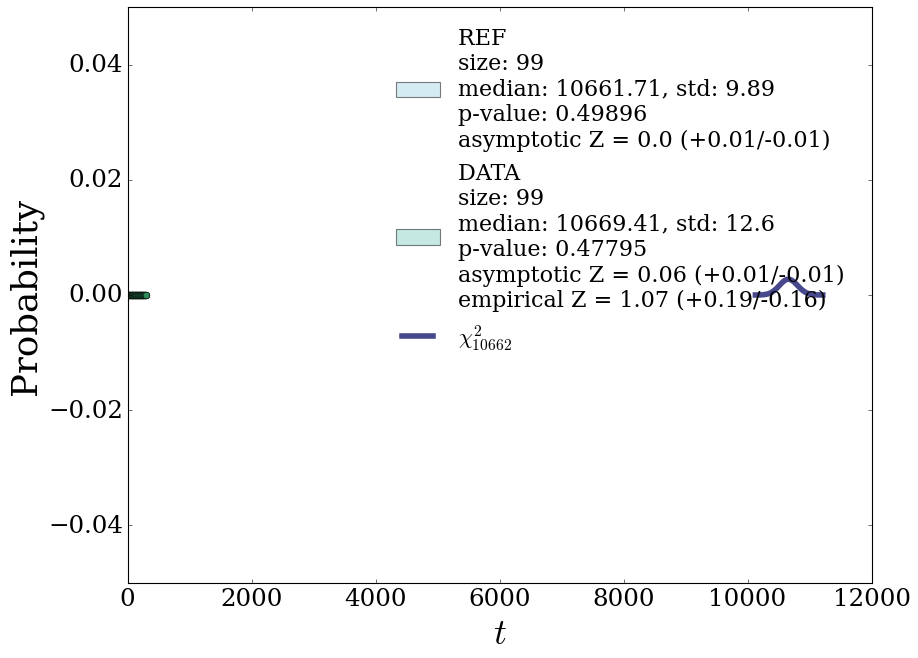

In [3]:
def Z_score_chi2(t, df):
    sf = chi2.sf(t, df)
    Z  = -norm.ppf(sf)
    return Z, sf

def plot_2distribution_like_example(
    t1, t2, df, output_path, xmin=0, xmax=300, ymax=None, nbins=10,
    save=True, label1='REF', label2='DATA', save_name='probability_plot', print_Zscore=True
):
    """Same look as your example: fonts 32,22, colors, legend, chi2 overlay."""
    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')

    bins = np.linspace(xmin, xmax, nbins + 1)
    binswidth = (xmax - xmin) / nbins

    # REF
    Z_obs, p_value_obs = Z_score_chi2(np.median(t1), df)
    t_obs_err = 1.2533 * np.std(t1) / np.sqrt(t1.shape[0])
    Z_obs_p, _ = Z_score_chi2(np.median(t1) + t_obs_err, df)
    Z_obs_m, _ = Z_score_chi2(np.median(t1) - t_obs_err, df)
    label = '%s \nsize: %i\nmedian: %s, std: %s\np-value: %s\n' % (
        label1, t1.shape[0], str(np.around(np.median(t1), 2)),
        str(np.around(np.std(t1), 2)), str(np.around(p_value_obs, 5))
    )
    if print_Zscore:
        label += 'asymptotic Z = %s (+%s/-%s)' % (
            str(np.around(Z_obs, 2)),
            str(np.around(Z_obs_p - Z_obs, 2)),
            str(np.around(Z_obs - Z_obs_m, 2))
        )

    h1 = plt.hist(
        t1, weights=np.ones_like(t1) / (t1.shape[0] * binswidth),
        color='lightblue', alpha=0.5, bins=bins, label=label
    )
    err1 = np.sqrt(h1[0] / (t1.shape[0] * binswidth))
    xcenters = 0.5 * (bins[1:] + bins[:-1])
    plt.errorbar(xcenters, h1[0], yerr=err1, color='#2c7fb8', marker='o', ls='')
    max1 = np.max(h1[0]) if len(h1[0]) else 0.0

    # DATA
    max2 = 0.0
    if len(t2):
        Z_obs2, p_value_obs2 = Z_score_chi2(np.median(t2), df)
        t_obs_err2 = 1.2533 * np.std(t2) / np.sqrt(t2.shape[0])
        Z_obs_p2, _ = Z_score_chi2(np.median(t2) + t_obs_err2, df)
        Z_obs_m2, _ = Z_score_chi2(np.median(t2) - t_obs_err2, df)

        t_empirical = np.sum(1.0 * (t1 > np.mean(t2))) / t1.shape[0]
        empirical_lim = '='
        if t_empirical == 0:
            empirical_lim = '>'
            t_empirical = 1.0 / t1.shape[0]
        t_empirical_err = t_empirical * np.sqrt(1.0 / (np.sum(1.0 * (t1 > np.mean(t2))) + 1.0 / t1.shape[0]))
        Z_empirical   = norm.ppf(1 - t_empirical)
        Z_empirical_m = norm.ppf(1 - (t_empirical + t_empirical_err))
        Z_empirical_p = norm.ppf(1 - (t_empirical - t_empirical_err))

        label = '%s \nsize: %i\nmedian: %s, std: %s\np-value: %s\n' % (
            label2, t2.shape[0], str(np.around(np.median(t2), 2)),
            str(np.around(np.std(t2), 2)), str(np.around(p_value_obs2, 5))
        )
        if print_Zscore:
            label += 'asymptotic Z = %s (+%s/-%s) \n' % (
                str(np.around(Z_obs2, 2)),
                str(np.around(Z_obs_p2 - Z_obs2, 2)),
                str(np.around(Z_obs2 - Z_obs_m2, 2))
            )
            label += 'empirical Z %s %s (+%s/-%s)' % (
                empirical_lim,
                str(np.around(Z_empirical, 2)),
                str(np.around(Z_empirical_p - Z_empirical, 2)),
                str(np.around(Z_empirical - Z_empirical_m, 2))
            )

        h2 = plt.hist(
            t2, weights=np.ones_like(t2) / (t2.shape[0] * binswidth),
            color='#8dd3c7', alpha=0.5, bins=bins, label=label
        )
        err2 = np.sqrt(h2[0] / (t2.shape[0] * binswidth))
        plt.errorbar(xcenters, h2[0], yerr=err2, color='seagreen', marker='o', ls='')
        max2 = np.max(h2[0]) if len(h2[0]) else 0.0

    # chi2 reference
    xgrid = np.linspace(chi2.ppf(0.0001, df), chi2.ppf(0.9999, df), 100)
    plt.plot(xgrid, chi2.pdf(xgrid, df), 'midnightblue', lw=5, alpha=0.8, label=r'$\chi^2_{%i}$' % (df))

    font = font_manager.FontProperties(family='serif', size=20)
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    plt.ylim(0., 1.2 * max(max1, max2))
    if ymax is not None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")

    if save:
        fn = os.path.join(output_path, save_name + '.pdf')
        plt.savefig(fn, bbox_inches="tight")
        print("Saved figure to:", fn)
    plt.show()
    plt.close()


if __name__ == "__main__":
    t_ref = _collect_mode_tests(BASE_DIR, "calibration")
    t_data = _collect_mode_tests(BASE_DIR, "comparison")

    if DF_OVERRIDE is None:
        if len(t_ref) == 0:
            raise RuntimeError("No REF toys found, set DF_OVERRIDE or check BASE_DIR")
        df_val = int(round(float(np.mean(t_ref))))
    else:
        df_val = int(round(float(DF_OVERRIDE)))

    plot_2distribution_like_example(
        t_ref, t_data, df_val,
        output_path=FIG_DIR,
        xmin=XMIN, xmax=XMAX, ymax=YMAX, nbins=NBINS,
        save=True, label1='REF', label2='DATA',
        save_name='probability_plot', print_Zscore=PRINT_Z
    )


In [4]:
import os, numpy as np, matplotlib.pyplot as plt
from matplotlib import font_manager
from scipy.stats import norm

plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0.0

from scipy.stats import norm, chi2

def Z_score_chi2(t, df):
    """Asymptotic Z from chi2 survival function (and its p-value)."""
    sf = chi2.sf(t, df)      # 1 - CDF
    Z  = -norm.ppf(sf)       # one-sided Z
    return Z, sf             # return (Z, p-value)

def Z_score_chi2_from_empirical_median(t, ref_df_like=None):
    med = np.median(t)
    t_obs_err = 1.2533 * np.std(t) / np.sqrt(len(t))
    p_emp = 0.5
    Z  = norm.ppf(1 - p_emp)
    Zp = norm.ppf(1 - min(0.999999, max(1e-6, p_emp - 0.5 * t_obs_err / (np.std(t) + 1e-12))))
    Zm = norm.ppf(1 - min(0.999999, max(1e-6, p_emp + 0.5 * t_obs_err / (np.std(t) + 1e-12))))
    return Z, Zp - Z, Z - Zm

def fd_bins(x):
    """Numero di bin secondo Freedman–Diaconis."""
    x = np.asarray(x, float)
    if len(x) < 2:
        return 5
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    h = 2 * iqr / (len(x) ** (1/3) + 1e-12)
    if h <= 0:
        return 10
    nb = int(np.ceil((x.max() - x.min()) / h))
    return max(5, nb)

def plot_2distribution_overlap(
    t1, t2, output_path, nbins=None, save=True,
    label1='REF', label2='DATA', save_name='probability_plot_nochi2',
    print_Zscore=True, ymax=None, show_expectation=True
):
    t1 = np.asarray(t1, float)
    t2 = np.asarray(t2, float)

    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')

    # bins: Freedman–Diaconis se nbins non è specificato
    t_all = np.concatenate([t1, t2]) if len(t2) else t1
    if nbins is None:
        nbins = fd_bins(t_all)
    bins = np.linspace(np.min(t_all), np.max(t_all), nbins + 1)
    binswidth = (np.max(t_all) - np.min(t_all)) / nbins

    # --- REF ---
    Zr, Zr_p, Zr_m = Z_score_chi2_from_empirical_median(t1)
    label = '%s \nsize: %i\nmedian: %s, std: %s\n' % (
        label1, t1.shape[0], str(np.around(np.median(t1), 2)),
        str(np.around(np.std(t1), 2))
    )
    if print_Zscore:
        label += 'asymptotic Z ≈ %s (+%s/-%s)' % (
            str(np.around(Zr, 2)),
            str(np.around(Zr_p, 2)),
            str(np.around(Zr_m, 2))
        )

    h1 = plt.hist(
        t1,
        weights=np.ones_like(t1) / (t1.shape[0] * binswidth),
        color="#e186ed", alpha=0.5,   # darker fill than before
        bins=bins, label=label,
        edgecolor='none', linewidth=0
    )
    xcenters = 0.5 * (bins[1:] + bins[:-1])
    err1 = np.sqrt(h1[0] / (t1.shape[0] * binswidth))
    plt.errorbar(
        xcenters, h1[0], yerr=err1,
        color="#8a2be2", marker='o', ls='', alpha=0.9,
        markersize=5, capsize=2, elinewidth=0.8
    )


    # --- DATA ---
    if len(t2):
        Zd, Zd_p, Zd_m = Z_score_chi2_from_empirical_median(t2)
        label = '%s \nsize: %i\nmedian: %s, std: %s\n' % (
            label2, t2.shape[0], str(np.around(np.median(t2), 2)),
            str(np.around(np.std(t2), 2))
        )
        if print_Zscore:
            label += 'asymptotic Z ≈ %s (+%s/-%s)' % (
                str(np.around(Zd, 2)),
                str(np.around(Zd_p, 2)),
                str(np.around(Zd_m, 2))
            )

        h2 = plt.hist(
            t2,
            weights=np.ones_like(t2) / (t2.shape[0] * binswidth),
            color="#68aedc", alpha=0.5,   # darker fill than before
            bins=bins, label=label,
            edgecolor='none', linewidth=0
        )
        err2 = np.sqrt(h2[0] / (t2.shape[0] * binswidth))
        plt.errorbar(
            xcenters, h2[0], yerr=err2,
            color="#004c99", marker='o', ls='', alpha=0.9,
            markersize=5, capsize=2, elinewidth=0.8
        )

    # --- styling ---
    font = font_manager.FontProperties(family='serif', size=17)
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    if ymax is not None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    plt.tight_layout()

    if save:
        fn = os.path.join(output_path, save_name + '.pdf')
        plt.savefig(fn, bbox_inches="tight", pad_inches=0.01)
        print("Saved figure to:", fn)
    plt.show()
    plt.close()


def plot_2distribution_overlap_new(
    t1, t2, output_path, nbins=None, save=True,
    label1='REF', label2='DATA', save_name='probability_plot_nochi2',
    print_Zscore=True, ymax=None, show_expectation=True
):
    t1 = np.asarray(t1, float)
    t2 = np.asarray(t2, float)

    plt.rcParams["font.family"] = "serif"
    plt.style.use('classic')
    fig = plt.figure(figsize=(12, 9))
    fig.patch.set_facecolor('white')

    # bins
    t_all = np.concatenate([t1, t2]) if len(t2) else t1
    if nbins is None:
        nbins = fd_bins(t_all)
    bins = np.linspace(np.min(t_all), np.max(t_all), nbins + 1)
    binswidth = (np.max(t_all) - np.min(t_all)) / nbins
    xcenters = 0.5 * (bins[1:] + bins[:-1])

    # ---- degrees of freedom: use override or mean(REF) ----
    df_local = DF_OVERRIDE if DF_OVERRIDE is not None else float(np.mean(t1))

    # --- REF ---  (chi2 Z at the median, with median error band)
    Zr, p_r = Z_score_chi2(np.median(t1), df_local)
    med_err_r = 1.2533 * np.std(t1) / np.sqrt(len(t1))
    Zr_p, _   = Z_score_chi2(np.median(t1) + med_err_r, df_local)
    Zr_m, _   = Z_score_chi2(np.median(t1) - med_err_r, df_local)

    label = (f'{label1} \nsize: {int(t1.shape[0]/2)}\n'
             f'median: {np.median(t1):.2f}, std: {np.std(t1):.2f}\n'
             f'p-value: {p_r:.5f}\n')
    if print_Zscore:
        label += f'asymptotic Z = {Zr:.2f} (+{Zr_p-Zr:.2f}/-{Zr-Zr_m:.2f})'

    h1 = plt.hist(
        t1,
        weights=np.ones_like(t1)/(t1.shape[0]*binswidth),
        color="#e186ed", alpha=0.5, bins=bins, label=label,
        edgecolor='none', linewidth=0
    )
    err1 = np.sqrt(h1[0] / (t1.shape[0] * binswidth))
    plt.errorbar(xcenters, h1[0], yerr=err1,
                 color="#8a2be2", marker='o', ls='', alpha=0.6,
                 markersize=5, capsize=2, elinewidth=0.8)

    # --- DATA --- (same chi2 Z; keep empirical tail if you like)
    if len(t2):
        Zd, p_d = Z_score_chi2(np.median(t2), df_local)
        med_err_d = 1.2533 * np.std(t2) / np.sqrt(len(t2))
        Zd_p, _   = Z_score_chi2(np.median(t2) + med_err_d, df_local)
        Zd_m, _   = Z_score_chi2(np.median(t2) - med_err_d, df_local)

        # empirical tail vs REF (optional; comment out if not needed)
        t_emp = np.sum(t1 > np.mean(t2)) / len(t1)
        empirical_lim = '=' if t_emp > 0 else '>'
        if t_emp == 0: t_emp = 1.0/len(t1)
        t_emp_err = t_emp * np.sqrt(1.0 / (np.sum(t1 > np.mean(t2)) + 1.0/len(t1)))
        Z_emp   = norm.ppf(1 - t_emp)
        Z_emp_m = norm.ppf(1 - (t_emp + t_emp_err))
        Z_emp_p = norm.ppf(1 - (t_emp - t_emp_err))

        label = (f'{label2} \nsize: {int(t2.shape[0]/2)}\n'
                 f'median: {np.median(t2):.2f}, std: {np.std(t2):.2f}\n'
                 f'p-value: {p_d:.5f}\n')
        if print_Zscore:
            label += (f'asymptotic Z = {Zd:.2f} (+{Zd_p-Zd:.2f}/-{Zd-Zd_m:.2f})\n'
                      f'empirical Z {empirical_lim} {Z_emp:.2f} '
                      f'(+{Z_emp_p-Z_emp:.2f}/-{Z_emp-Z_emp_m:.2f})')

        h2 = plt.hist(
            t2,
            weights=np.ones_like(t2)/(t2.shape[0]*binswidth),
            color="#68aedc", alpha=0.5, bins=bins, label=label,
            edgecolor='none', linewidth=0
        )
        err2 = np.sqrt(h2[0] / (t2.shape[0] * binswidth))
        plt.errorbar(xcenters, h2[0], yerr=err2,
                     color="#004c99", marker='o', ls='', alpha=0.6,
                     markersize=5, capsize=2, elinewidth=0.8)

    # --- styling ---
    font = font_manager.FontProperties(family='serif', size=16.5)
    plt.legend(ncol=1, loc='upper right', prop=font, frameon=False)
    plt.xlabel('$t$', fontsize=32, fontname="serif")
    plt.ylabel('Probability', fontsize=32, fontname="serif")
    if ymax is not None:
        plt.ylim(0., ymax)
    plt.yticks(fontsize=22, fontname="serif")
    plt.xticks(fontsize=22, fontname="serif")
    plt.tight_layout()

    if save:
        fn = os.path.join(output_path, save_name + '.pdf')
        plt.savefig(fn, bbox_inches="tight", pad_inches=0.01)
        print("Saved figure to:", fn)
    plt.show()
    plt.close()


Saved figure to: ./plots/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax/probability_plot_overlap_check.pdf


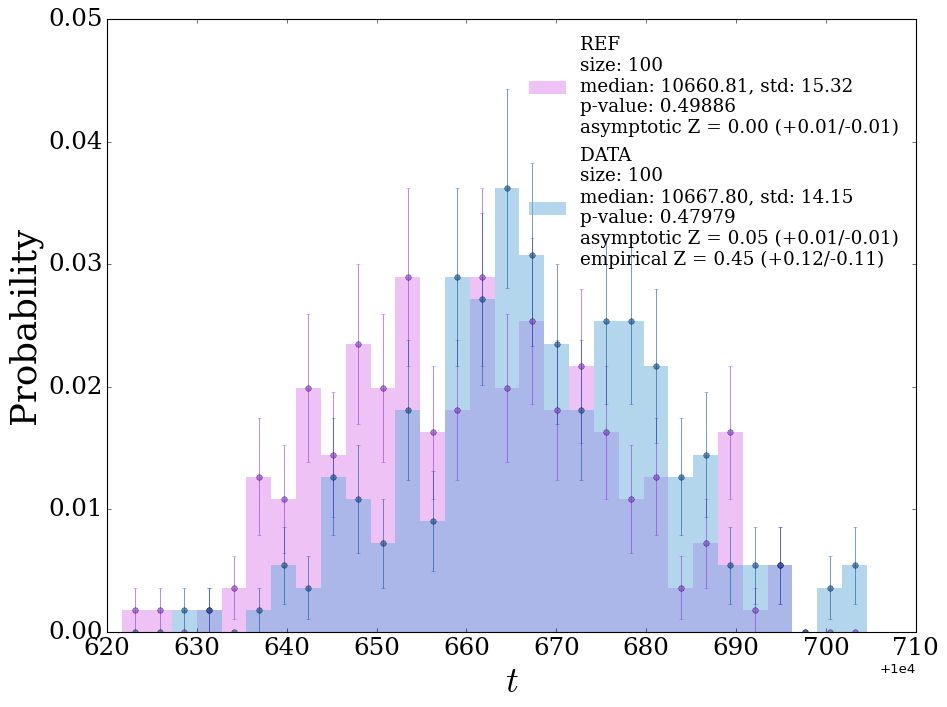

In [5]:
if __name__ == "__main__":
    import numpy as np
    
    # Example toys (replace with your collect function)
    np.random.seed(0)
    t_ref = np.random.normal(loc=10660, scale=15, size=200)
    t_data = np.random.normal(loc=10670, scale=15, size=200)

    FIG_DIR = "./plots/N_100000_dim_2_seeds_60_4_16_128_15_toys_100_N_sampled_100k_20_kernels_no_softmax/"
    os.makedirs(FIG_DIR, exist_ok=True)

    plot_2distribution_overlap_new(
        t_ref, t_data,
        output_path=FIG_DIR,
        nbins=30,
        save=True,
        label1='REF',
        label2='DATA',
        
        save_name='probability_plot_overlap_check',
        print_Zscore=True,
        show_expectation=True   # gray ±1σ band for chi2 expectation
    )


In [43]:
print("len(t_ref) =", len(t_ref))
print("len(t_data) =", len(t_data))


len(t_ref) = 200
len(t_data) = 200
